# 3D Printer DataSet for Mechanical Engineers

# Project :
This dataset concerns the *3D printing process* and aims to study how various manufacturing parameters influence the *mechanical* and *surface* properties of printed parts. Each row in the dataset represents a printing experiment with different settings and corresponding performance measurements.


The goal of the project is to model and understand the impact of 3D printing parameters on the mechanical and surface properties of the produced parts. This would help optimize print settings to *find a balance between strength, quality, and speed, predict part performance* before printing, and reduce experimental trials and material waste.

## 1) descriptive analysis of your data


### The explanatory variables are as follows:

1.⁠ ⁠*layer_height*: the thickness of each printed layer. Smaller layers improve precision and surface finish but increase print time.

2.⁠ ⁠*wall_thickness*: thickness of the outer walls of the part, influencing strength and stiffness.

3.⁠ ⁠*infill_density*: percentage of material inside the part (0 to 100). Higher density increases strength but also material usage and print time.

4.⁠ ⁠*infill_pattern*: internal filling pattern (for example grid, honeycomb), affecting stress distribution and weight.

5.⁠ ⁠*nozzle_temperature*: temperature at which the filament is extruded, impacting layer adhesion and surface quality.

6.⁠ ⁠*bed_temperature*: temperature of the print bed, affecting first-layer adhesion and warping.

7.⁠ ⁠*print_speed*: speed of the print head. Higher speed reduces production time but may decrease quality.

8.⁠ ⁠*material*: type of filament used (for example ABS, PLA, PETG), each with distinct physical and thermal properties.

9.⁠ ⁠*fan_speed*: cooling fan speed, controlling the rate of cooling after extrusion and affecting strength and finish.

### The target variables are:

1.⁠ ⁠*roughness*: measure of surface texture, an indicator of visual quality and dimensional accuracy.

2.⁠ ⁠*tension_strength*: tensile strength, the maximum stress before failure.

3.⁠ ⁠*elongation*: ability of the material to deform before breaking, a measure of ductility.

In [1]:
# Imports généraux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pprint import pprint

# scikit-learn
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# affichage inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
sns.set(style="whitegrid")


# Predicting Tensile Strength of 3D-Printed Parts

## 1. Business Case
This project addresses the challenge of optimizing 3D printing parameters for mechanical parts. 

* **Problem:** Testing the tensile strength of a 3D-printed part is a *destructive process*. It is costly in terms of material, machine time, and testing equipment.
* **Objective:** The goal is to build a machine learning model that can **predict the final tensile strength** of a part based *only* on its printing parameters (like material, layer height, infill density) and other non-destructive measurements.
* **Business Value:** This model would allow engineers to virtually iterate and optimize print settings to meet specific strength requirements *before* committing to a print, saving significant time and resources. This is directly related to [Votre Spécialisation, ex: Industrial Engineering, Robotics, Materials Science].

In [2]:
# Charger le dataset
path = 'data.csv' 
df = pd.read_csv(path)
print("Shape :", df.shape)
display(df.head(10))
print("\nInfo :")
print(df.info())
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())


Shape : (50, 12)


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7
5,0.02,10,40,honeycomb,200,60,40,pla,0,60,24,1.1
6,0.02,5,10,grid,205,65,40,pla,25,55,12,1.3
7,0.02,10,10,honeycomb,210,70,40,pla,50,21,14,1.5
8,0.02,9,70,grid,215,75,40,pla,75,24,27,1.4
9,0.02,8,40,honeycomb,220,80,40,pla,100,30,25,1.7



Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tension_strenght    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB
None

Valeurs manquantes par colonne :
layer_height          0
wall_thickness        0
infill_density        0
infill_pattern        0
nozzle

In [3]:
import pandas as pd
Data = pd.read_csv("data.csv", sep = ",")

In [4]:
Data

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7
5,0.02,10,40,honeycomb,200,60,40,pla,0,60,24,1.1
6,0.02,5,10,grid,205,65,40,pla,25,55,12,1.3
7,0.02,10,10,honeycomb,210,70,40,pla,50,21,14,1.5
8,0.02,9,70,grid,215,75,40,pla,75,24,27,1.4
9,0.02,8,40,honeycomb,220,80,40,pla,100,30,25,1.7


In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()   #Encodage des données qualitative

# Encodage
Data['material'] = encoder.fit_transform(Data['material'])
Data['infill_pattern'] = encoder.fit_transform(Data['infill_pattern'])
Data


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,0,220,60,40,0,0,25,18,1.2
1,0.02,7,90,1,225,65,40,0,25,32,16,1.4
2,0.02,1,80,0,230,70,40,0,50,40,8,0.8
3,0.02,4,70,1,240,75,40,0,75,68,10,0.5
4,0.02,6,90,0,250,80,40,0,100,92,5,0.7
5,0.02,10,40,1,200,60,40,1,0,60,24,1.1
6,0.02,5,10,0,205,65,40,1,25,55,12,1.3
7,0.02,10,10,1,210,70,40,1,50,21,14,1.5
8,0.02,9,70,0,215,75,40,1,75,24,27,1.4
9,0.02,8,40,1,220,80,40,1,100,30,25,1.7


In [6]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     int64  
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     int64  
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tension_strenght    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(10)
memory usage: 4.8 KB


## 2) EDA (Exploration des données)
- Statistiques de base des colonnes numériques.
- Distribution des variables clés.
- Matrice de corrélation pour détecter relations fortes / fuites.


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
layer_height,50.0,NaN,NaN,NaN,0.106,0.064397,0.02,0.06,0.1,0.15,0.2
wall_thickness,50.0,NaN,NaN,NaN,5.22,2.922747,1.0,3.0,5.0,7.0,10.0
infill_density,50.0,NaN,NaN,NaN,53.4,25.36348,10.0,40.0,50.0,80.0,90.0
infill_pattern,50,2,grid,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nozzle_temperature,50.0,NaN,NaN,NaN,221.5,14.820353,200.0,210.0,220.0,230.0,250.0
bed_temperature,50.0,NaN,NaN,NaN,70.0,7.142857,60.0,65.0,70.0,75.0,80.0
print_speed,50.0,NaN,NaN,NaN,64.0,29.6923,40.0,40.0,60.0,60.0,120.0
material,50,2,abs,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fan_speed,50.0,NaN,NaN,NaN,50.0,35.714286,0.0,25.0,50.0,75.0,100.0
roughness,50.0,NaN,NaN,NaN,170.58,99.034129,21.0,92.0,165.5,239.25,368.0


Colonnes catégorielles : ['infill_pattern', 'material']

Valeurs de 'infill_pattern':
infill_pattern
grid         25
honeycomb    25
Name: count, dtype: int64

Valeurs de 'material':
material
abs    25
pla    25
Name: count, dtype: int64


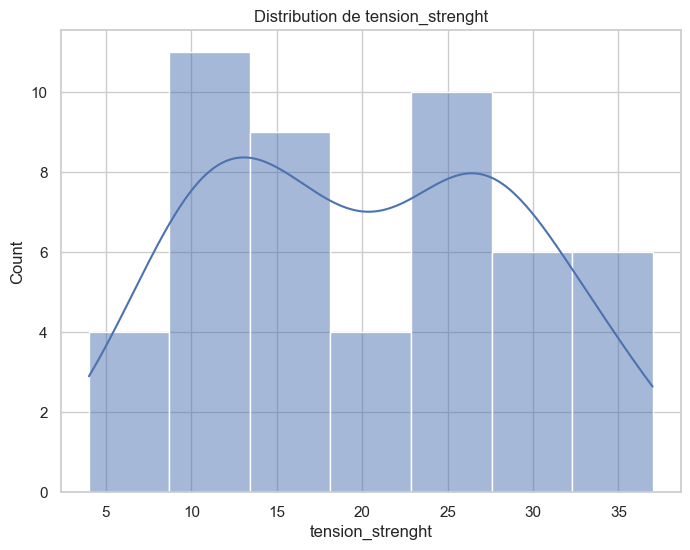

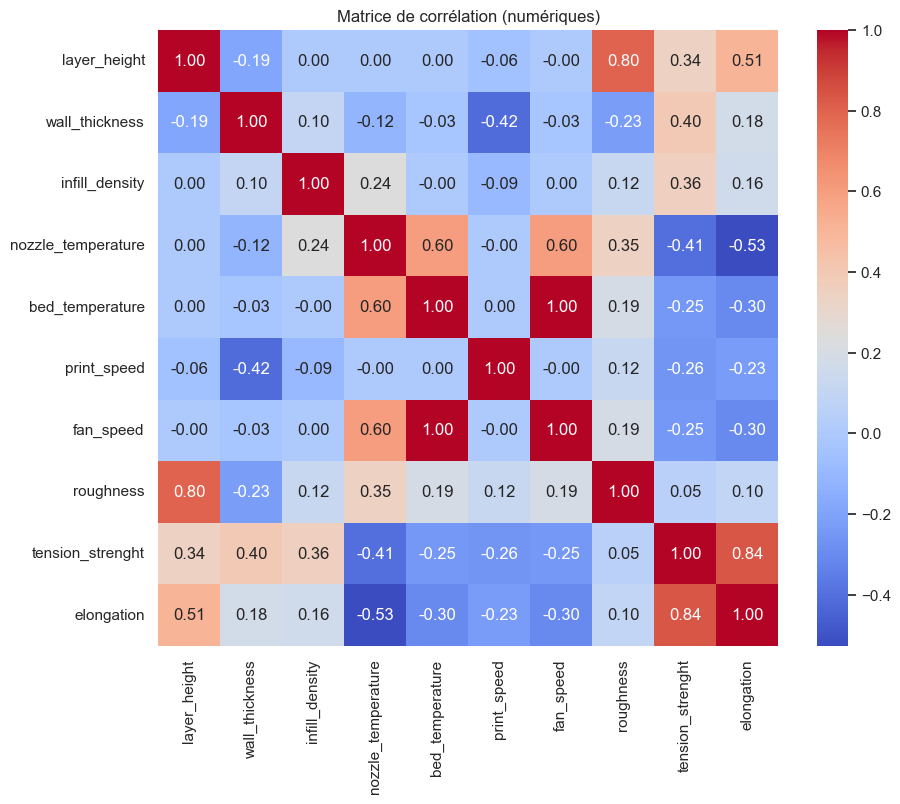

In [7]:
# Statistiques descriptives
display(df.describe(include='all').T)

# Colonnes catégorielles
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Colonnes catégorielles :", cat_cols)
for c in cat_cols:
    print(f"\nValeurs de '{c}':")
    print(df[c].value_counts())

# Distribution de la target
plt.figure()
sns.histplot(df['tension_strenght'], kde=True)
plt.title('Distribution de tension_strenght')
plt.show()

# Corrélation (numérique)
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation (numériques)')
plt.show()


**Remarque EDA :** si certaines colonnes numériques (ex : `elongation`, `roughness`) sont fortement corrélées à `tension_strenght`, il faut décider si on les garde (analyse post-mesure) ou si on les retire (prédiction pré-production).


In [8]:
# Afficher corrélation triée avec la target
corr_with_target = df[num_cols].corr()['tension_strenght'].sort_values(ascending=False)
print("Corrélations avec tension_strenght :")
print(corr_with_target) 

Corrélations avec tension_strenght :
tension_strenght      1.000000
elongation            0.838109
wall_thickness        0.399849
infill_density        0.358464
layer_height          0.338230
roughness             0.051617
bed_temperature      -0.252883
fan_speed            -0.252883
print_speed          -0.264590
nozzle_temperature   -0.405908
Name: tension_strenght, dtype: float64


## 3) Prétraitement et préparation des features
- Imputation, scaling pour numériques.
- One-Hot Encoding pour catégoriques.
- Séparation train/test (80/20).
- Nous garderons la possibilité d'exécuter une variante "sans fuite" plus tard.


In [9]:
TARGET = 'tension_strenght'
assert TARGET in df.columns, f"Target {TARGET} non trouvée"

# Features / target      
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

# Identifier types
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

print("Features numériques :", numeric_features)
print("Features catégorielles :", categorical_features)


Features numériques : ['layer_height', 'wall_thickness', 'infill_density', 'nozzle_temperature', 'bed_temperature', 'print_speed', 'fan_speed', 'roughness', 'elongation']
Features catégorielles : ['infill_pattern', 'material']


In [10]:
# Pipelines de preprocessing
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    )])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


## 4) Modèles de base & validation
- Linear Regression (baseline interprétable).
- Random Forest (baseline non-linéaire).
- CV 5-fold sur l'ensemble d'entraînement.


In [11]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipelines modèles
lr_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
rf_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Cross-validation (R2)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
lr_cv_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=cv, scoring='r2')
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=cv, scoring='r2')

print(f"LR CV mean R2: {lr_cv_scores.mean():.4f} (std {lr_cv_scores.std():.4f})")
print(f"RF CV mean R2: {rf_cv_scores.mean():.4f} (std {rf_cv_scores.std():.4f})")

# Entraînement sur tout l'entraînement
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# Prédictions test
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

# Fonctions métriques
def regression_report(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

results = {
    'LinearRegression': regression_report(y_test, y_pred_lr),
    'RandomForest': regression_report(y_test, y_pred_rf)
}

pprint(results)


LR CV mean R2: 0.5127 (std 0.1132)
RF CV mean R2: 0.6781 (std 0.1403)
{'LinearRegression': {'MAE': 3.755096141012378,
                      'R2': 0.7682617565282078,
                      'RMSE': 19.28293923928783},
 'RandomForest': {'MAE': 3.9240000000000004,
                  'R2': 0.7211561110443456,
                  'RMSE': 23.202599999999997}}


## 5) Visualisations & diagnostics
- Actual vs Predicted.
- Résidus.
- Importance des features (RF).


Meilleur modèle sur le test : LinearRegression


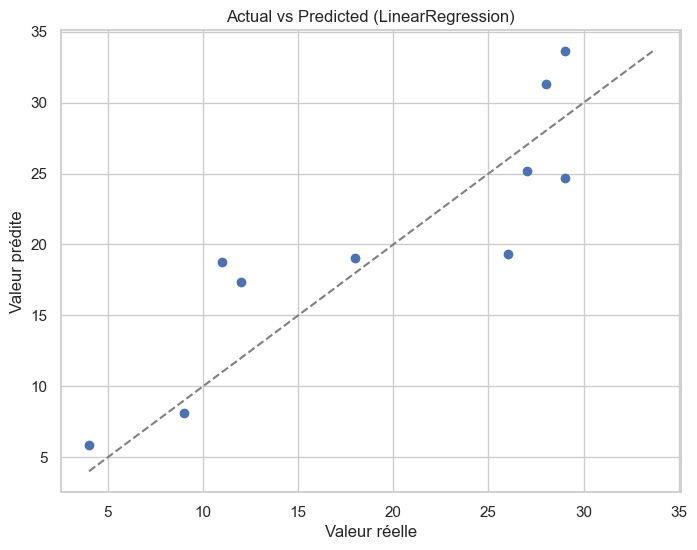

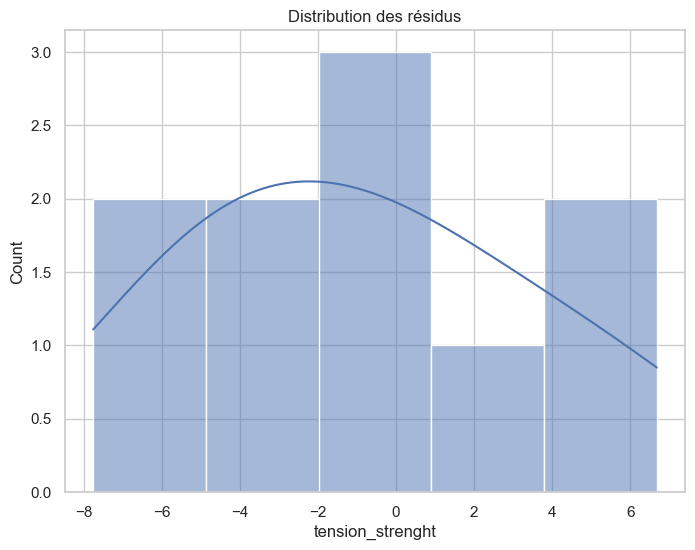

,feature,importance
8,elongation,0.726746
2,infill_density,0.108198
1,wall_thickness,0.066447
7,roughness,0.020593
3,nozzle_temperature,0.016544
4,bed_temperature,0.013264
0,layer_height,0.010272
6,fan_speed,0.009476
5,print_speed,0.009409
12,material_pla,0.006071


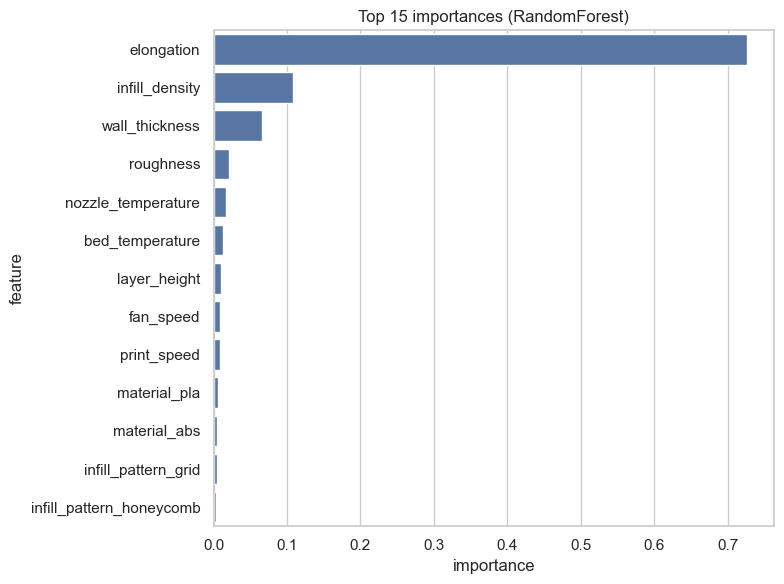

In [12]:
# Choisir le meilleur modèle selon R2 sur test pour tracer Actual vs Predicted
best_name = 'LinearRegression' if results['LinearRegression']['R2'] >= results['RandomForest']['R2'] else 'RandomForest'
print("Meilleur modèle sur le test :", best_name)

y_best = y_pred_lr if best_name == 'LinearRegression' else y_pred_rf

# Scatter Actual vs Predicted
plt.figure()
plt.scatter(y_test, y_best)
minv, maxv = min(y_test.min(), y_best.min()), max(y_test.max(), y_best.max())
plt.plot([minv, maxv], [minv, maxv], '--', color='gray')
plt.xlabel('Valeur réelle')
plt.ylabel('Valeur prédite')
plt.title(f'Actual vs Predicted ({best_name})')
plt.show()

# Residuals
residuals = y_test - y_best
plt.figure()
sns.histplot(residuals, kde=True)
plt.title('Distribution des résidus')
plt.show()

# Feature importances (RandomForest)
preproc_fit = rf_pipeline.named_steps['preprocessor']
# reconstruire les noms des features après encodage
num_feats = numeric_features
if categorical_features:
    ohe = preproc_fit.named_transformers_['cat'].named_steps['onehot']
    cat_feats = list(ohe.get_feature_names_out(categorical_features))
else:
    cat_feats = []
feature_names = num_feats + cat_feats

rf_model = rf_pipeline.named_steps['regressor']
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
display(feat_imp.head(20))

# Plot top importances
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(15))
plt.title('Top 15 importances (RandomForest)')
plt.tight_layout()
plt.show()


## 6) Analyse critique (fuite de données / data leakage)
- Si des caractéristiques mesurées après production (ex : `elongation`, `roughness`) sont utilisées comme features, cela peut provoquer une fuite d'information si l'objectif est prédire la résistance **avant** fabrication.
- Deux scénarios :
  - **Scénario A (post-mesure)** : on accepte ces features -> but : expliquer relations entre propriétés mesurées.
  - **Scénario B (pré-production)** : on retire ces features -> modèle utilisable avant fabrication.


In [13]:
# Vérifier si 'elongation' et 'roughness' existent et leur corrélation avec la target
for c in ['elongation','roughness']:
    if c in df.columns:
        corr = df[[c,TARGET]].corr().iloc[0,1]
        print(f"Corrélation {c} vs {TARGET} : {corr:.4f}")


Corrélation elongation vs tension_strenght : 0.8381
Corrélation roughness vs tension_strenght : 0.0516


In [14]:
print("test github")

test github


In [1]:
print("test github pour Loick")

test github pour Loick


In [2]:
print("test github pour harish")

test github pour harish


In [15]:
print("test github pour la nouvelle branche Lilian")

test github pour la nouvelle branche Lilian
